# Advanced Lane Lines

In [191]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
from lesson_functions import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
import time
import pickle
from scipy.ndimage.measurements import label

print("All module loaded")

All module loaded


## Color Features

In [7]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

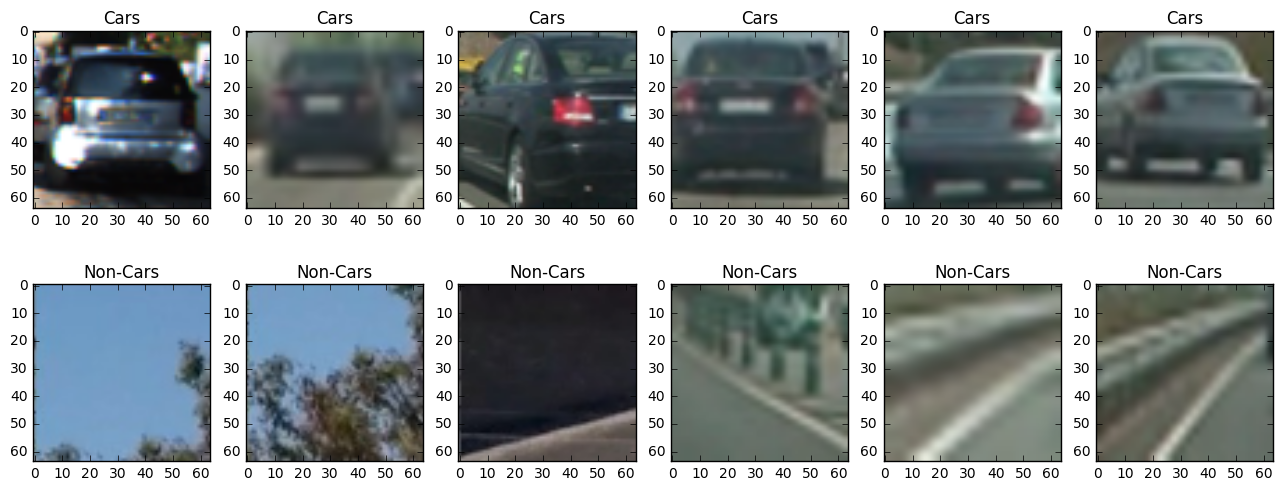

In [8]:
test_image = []
num_of_test_images = 12

for i in range(0,num_of_test_images):
    test_image.append(mpimg.imread("test_cars/%d.png"%i))
%matplotlib inline

f, axarr = plt.subplots(2, 6,figsize=(16, 6))
for i in range(0,2):
    for j in range((int)(num_of_test_images/2)):
        if i == 0:
            axarr[i][j].set_title('Cars')
        else:
            axarr[i][j].set_title('Non-Cars')
        axarr[i][j].imshow(test_image[(int)(num_of_test_images/2)*i+j])

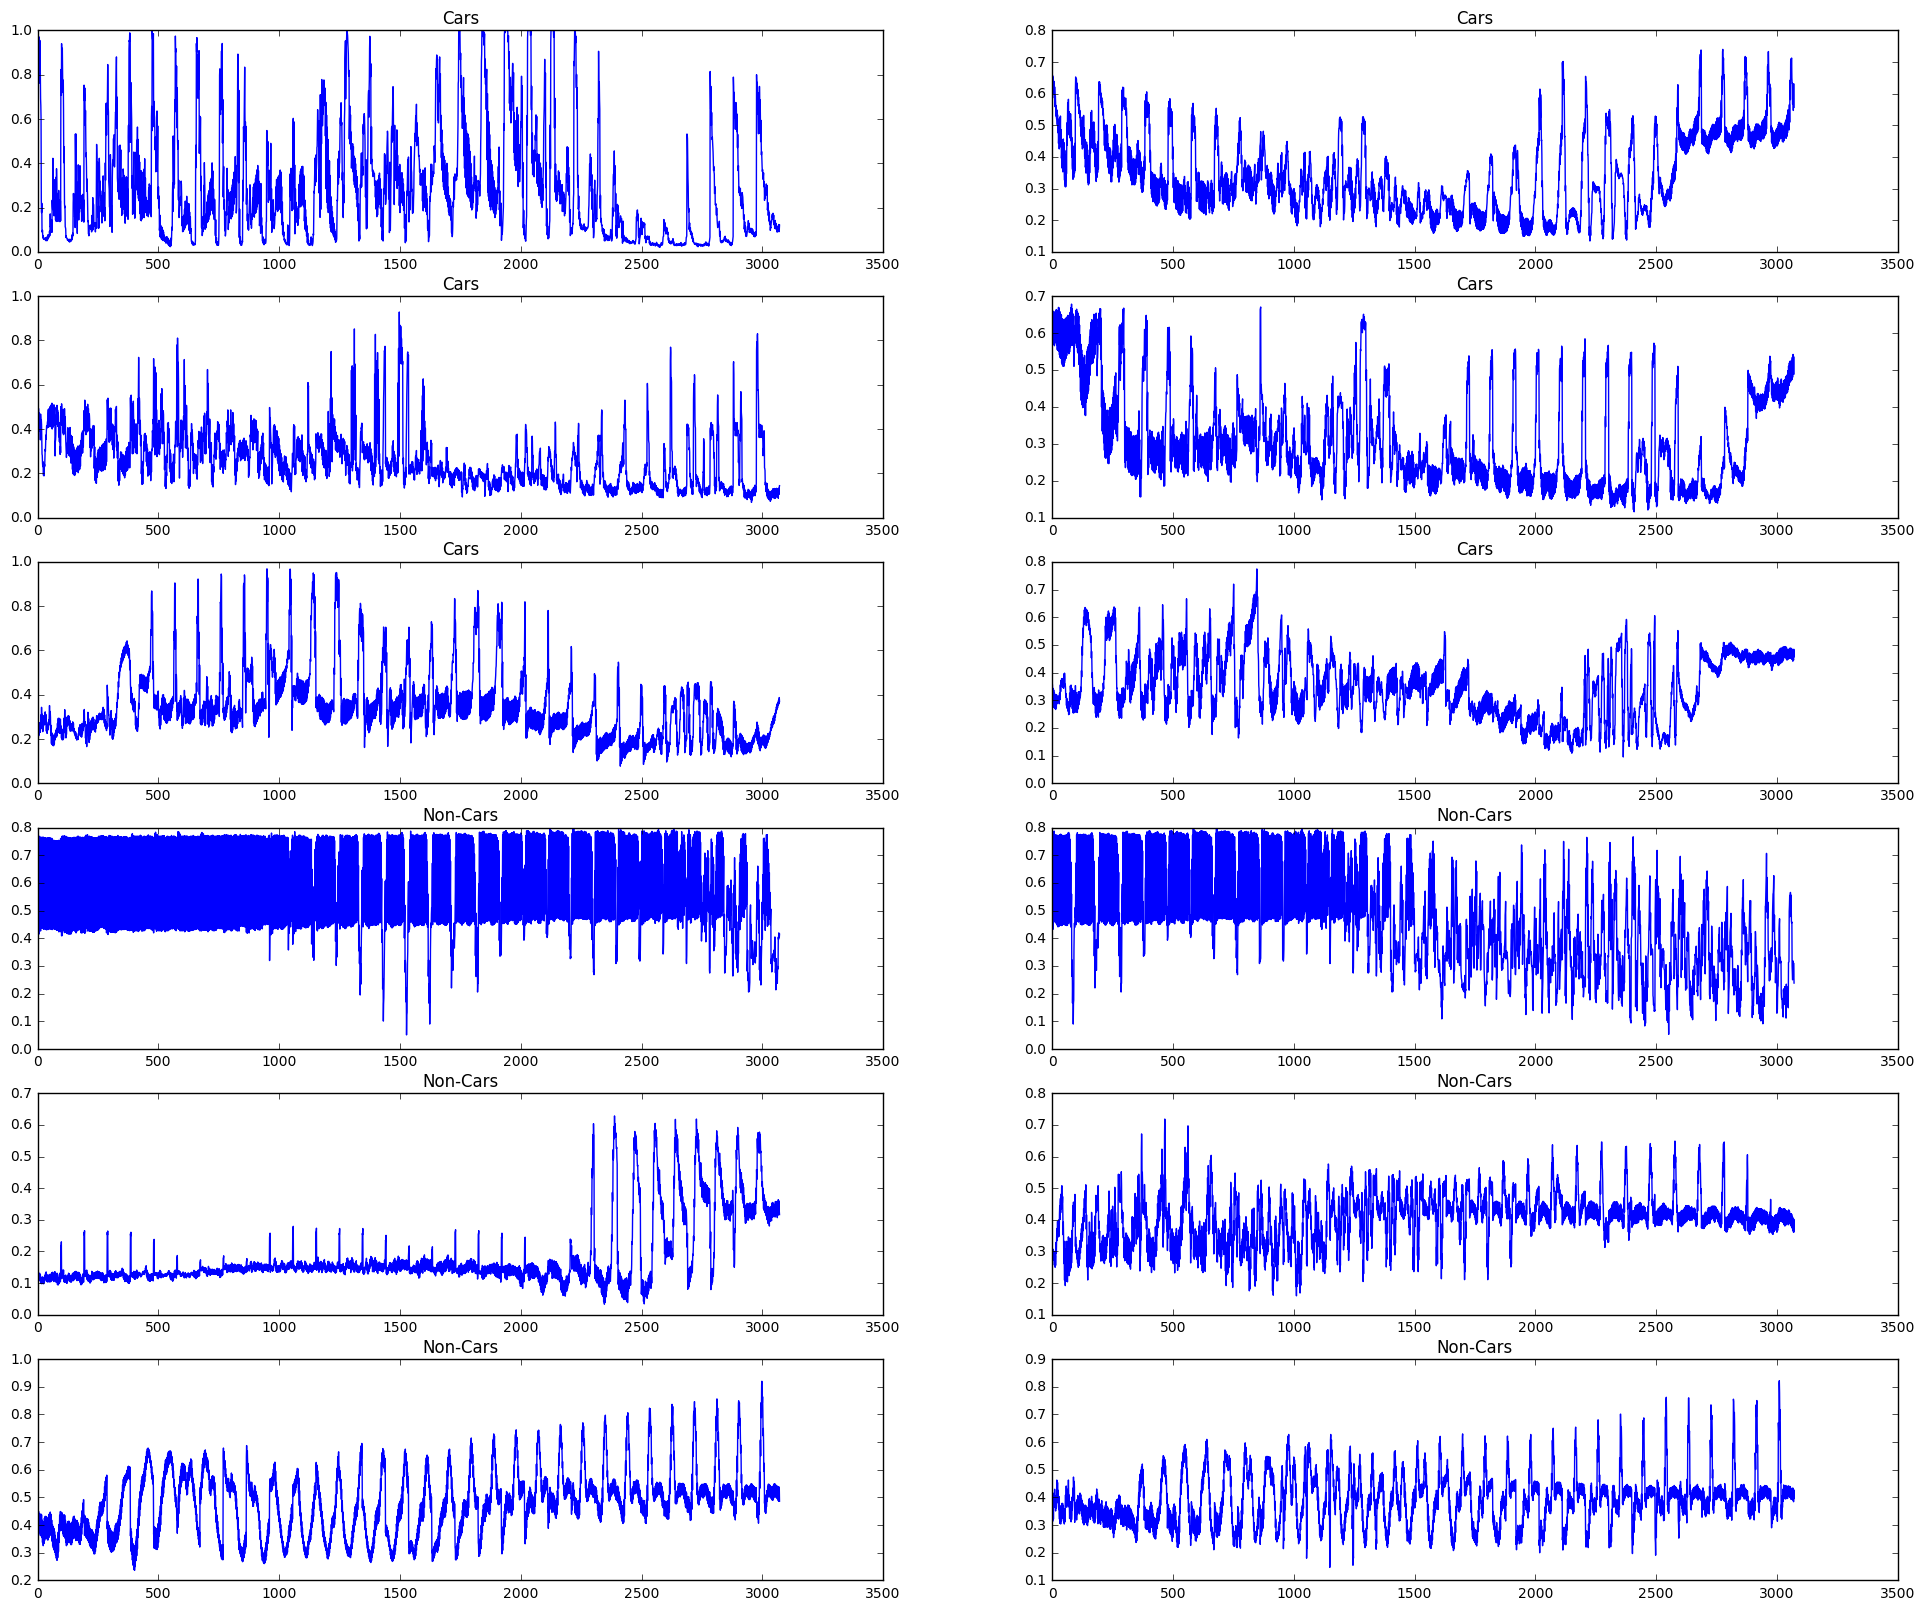

In [9]:
# Plot features
ff, axarrr = plt.subplots(6, 2,figsize=(24, 20))
plt.title('Spatially Binned Features')
for i in range((int)(num_of_test_images/2)):
    for j in range(0,2):
        if i < 3:
            axarrr[i][j].set_title('Cars')
        else:
            axarrr[i][j].set_title('Non-Cars')
        feature_vec = bin_spatial(test_image[i*2 + j], color_space='RGB', size=(32, 32))
        axarrr[i][j].plot(feature_vec)


## HOG Features

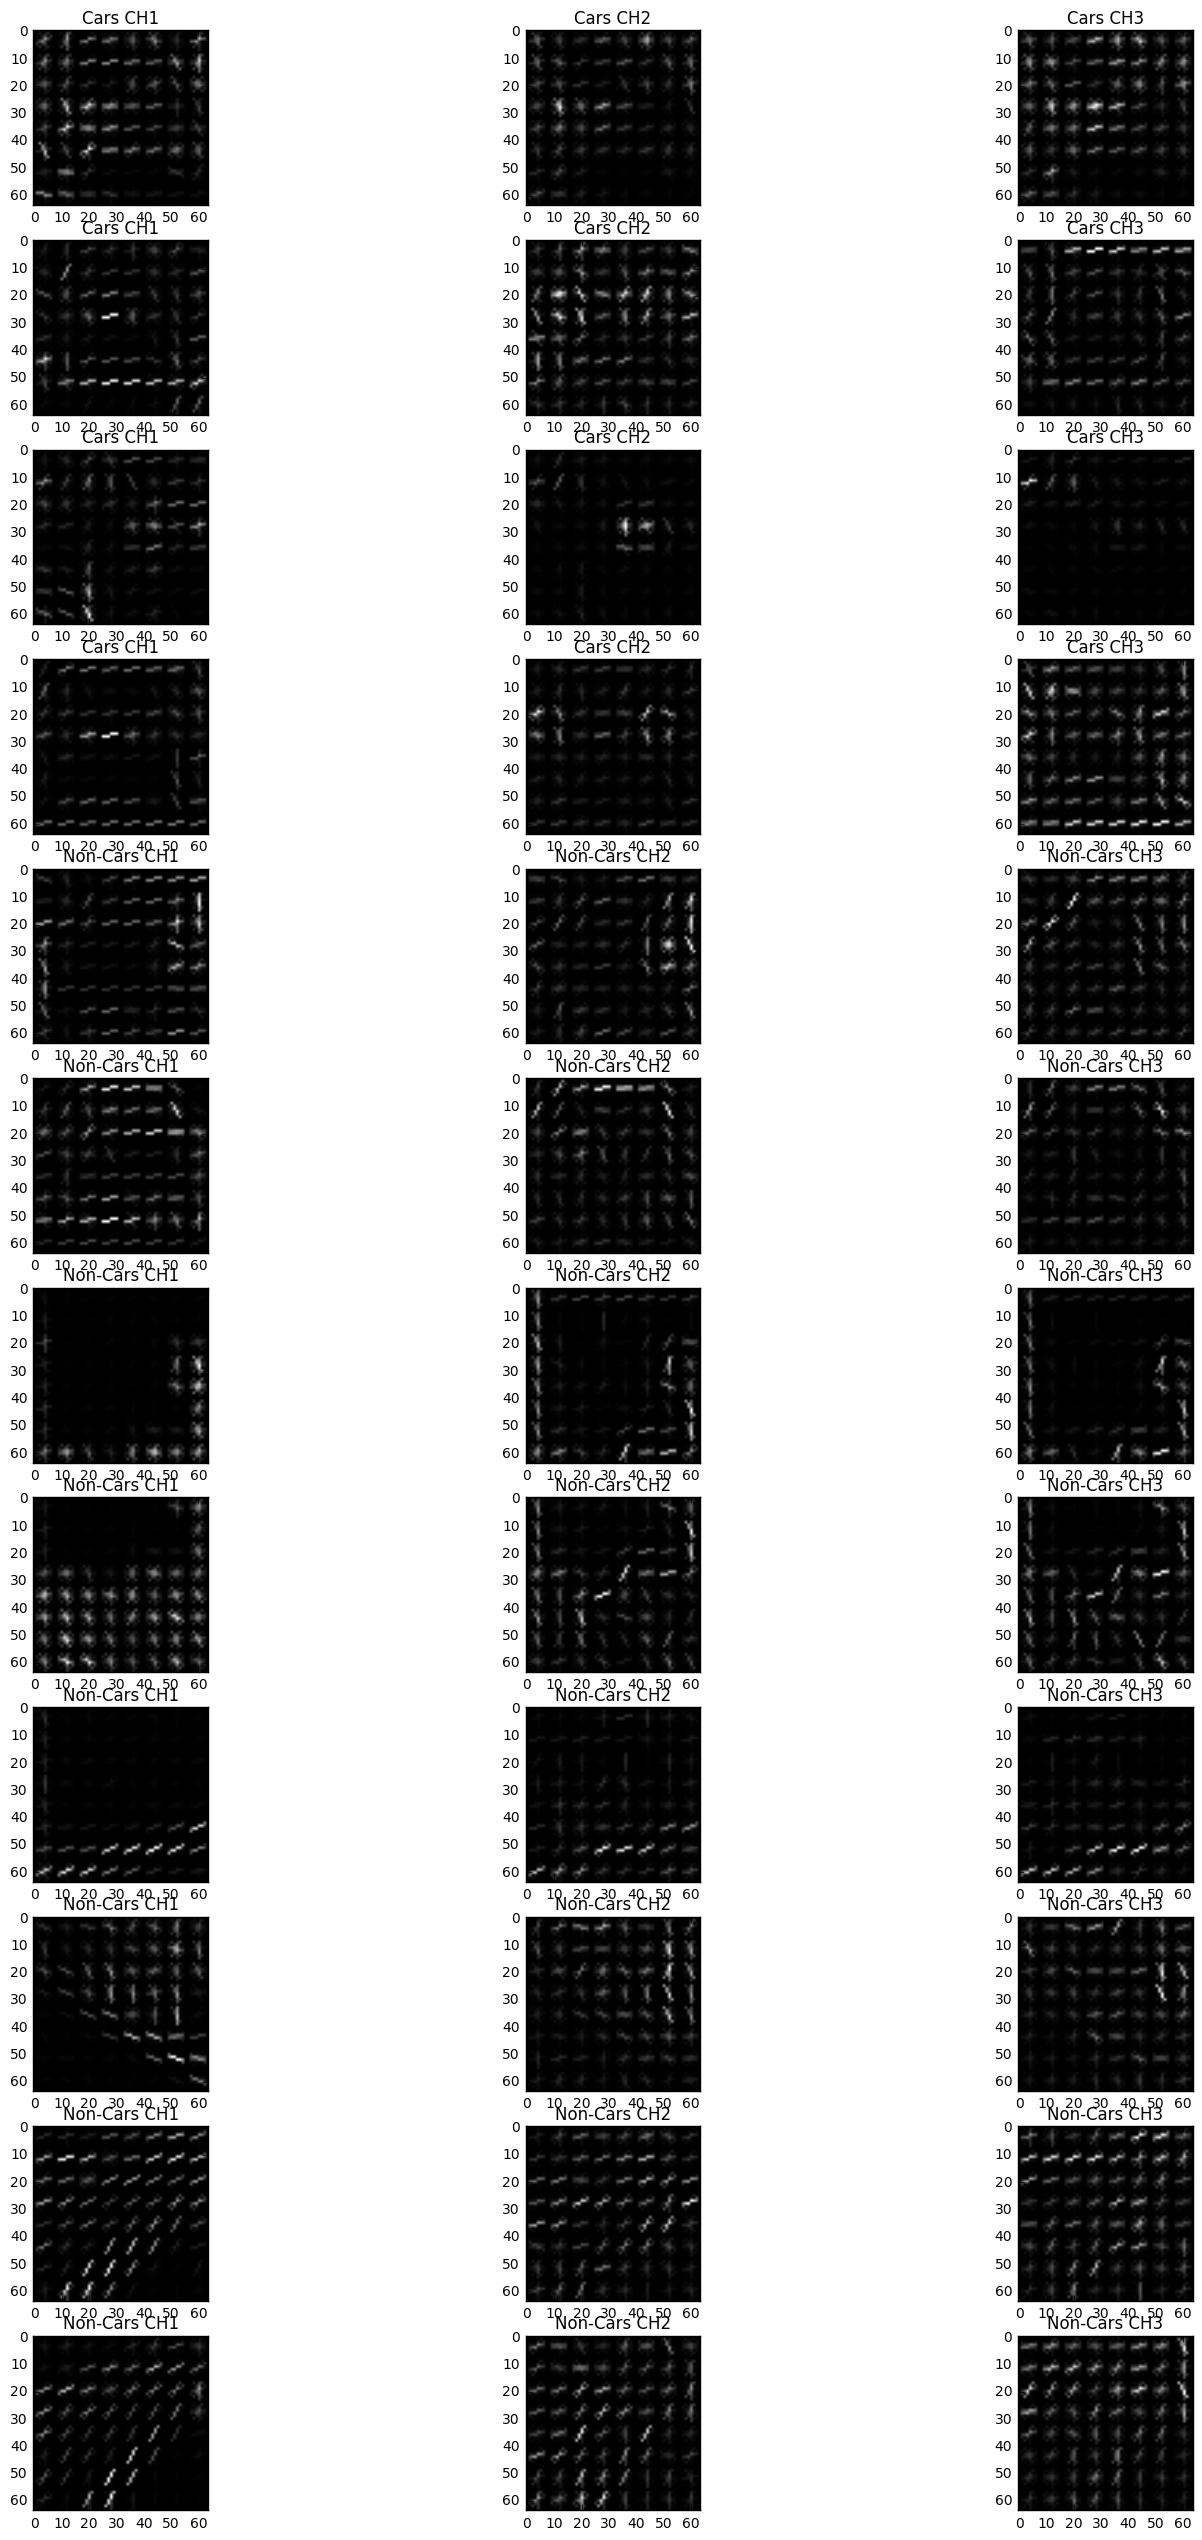

In [10]:
f, axarr = plt.subplots(num_of_test_images, 3,figsize=(18, 32))
for i in range(0,num_of_test_images):   
    ctrans_tosearch = convert_color(test_image[i], conv='RGB2YCrCb')
    
    for j in range(0, 3):
        [features, hog_image] = get_hog_features(ctrans_tosearch[:,:,j], orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=True, feature_vec=True)
        s = "CH1"
        if j == 0:
            s = "CH1"
        elif j == 1:
            s = "CH2"
        else:
            s = "CH3"
            
        if i < num_of_test_images/3:
            axarr[i][j].set_title('Cars '+s)
        else:
            axarr[i][j].set_title('Non-Cars '+s)
            
        axarr[i][j].imshow(hog_image, cmap='gray')
        

## Hog Classifier

In [11]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [12]:
# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

len(notcars)



8968

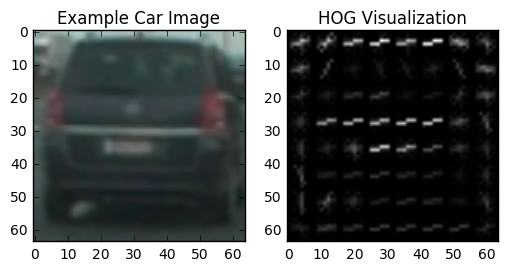

In [13]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [14]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [198]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

54.5 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
13.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9825
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00096 Seconds to predict 10 labels with SVC


In [199]:
D = {'svc':svc,'scaler':X_scaler,'orient':orient,'cell_per_block':cell_per_block,'pix_per_cell':pix_per_cell,'spatial_size':(32,32),'hist_bins':32}
f = open('svc_pickle.p','wb')
pickle.dump(D,f)
f.close()
print("Parameter Saved")





Parameter Saved


In [200]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
print("Parameter Opened")

Parameter Opened


In [201]:
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
    boxes = []
    i = 0
    for scale in scales:
        print (scale)
        
        i += 1
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
    #             spatial_features = bin_spatial(subimg, size=spatial_size)
    #             hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    boxes.append([[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])
    return [draw_img, boxes]
    


1.5


16

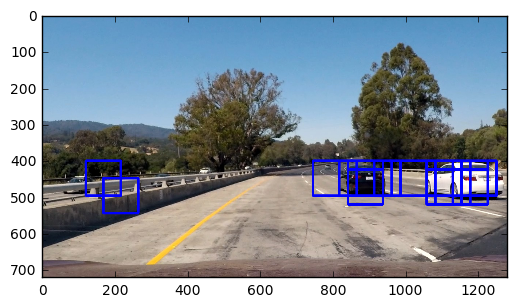

In [247]:
img = mpimg.imread("test_images/test1.jpg")

ystart = 400
ystop = 656
scale = 1
spatial_size = (32,32)
hist_bins = 32
    
[out_img, boxes] = find_cars(img, 400, 656, [1.5], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
len(boxes)


In [204]:
boxes

[[[120, 400], [216, 496]],
 [[168, 448], [264, 544]],
 [[744, 400], [840, 496]],
 [[816, 400], [912, 496]],
 [[840, 400], [936, 496]],
 [[840, 424], [936, 520]],
 [[864, 400], [960, 496]],
 [[960, 400], [1056, 496]],
 [[984, 400], [1080, 496]],
 [[1056, 400], [1152, 496]],
 [[1056, 424], [1152, 520]],
 [[1080, 400], [1176, 496]],
 [[1080, 424], [1176, 520]],
 [[1128, 400], [1224, 496]],
 [[1128, 424], [1224, 520]],
 [[1152, 400], [1248, 496]],
 [[64, 400], [192, 528]],
 [[96, 400], [224, 528]],
 [[512, 400], [640, 528]]]

## Heat Map

I used the straight line image for testing, then choose the area for perspective transform approximitely. The result shows two lines parallely to each other approximitely, just as we expected.

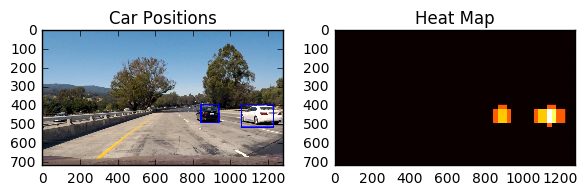

In [250]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()



## Final Code

In [259]:
# frame_boxes = []
filter_frame = 12
# for i in range(0,filter_frame):
#     frame_boxes.append([[[0, 0], [0, 0]]])

heat_frames = []
for i in range(0,filter_frame):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_frames.append(heat)

In [260]:
def detect_cars(image):
    [rough_img, boxes] = find_cars(image,  400, 656, [1.5,2,3], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat_combine = np.zeros_like(image[:,:,0]).astype(np.float)
    
#     if boxes == []:
#         boxes = [[[0, 0], [0, 0]]]
        
#     for i in range(0,filter_frame-1):
#         frame_boxes[i] = frame_boxes[i+1]
    
#     frame_boxes[filter_frame-1] = boxes
    
#     bo = [[[0, 0], [0, 0]]]
#     for i in range(0,filter_frame):
#         bo = np.concatenate((bo,frame_boxes[i]))

    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    
    
    for i in range(0,filter_frame-1):
        heat_frames[i] = heat_frames[i+1]
    heat_frames[filter_frame-1] = heat
    
    for i in range(0,filter_frame):
        heat_combine += heat_frames[i]
    heat_combine = apply_threshold(heat_combine,4)
    
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_combine, 0, 255)


    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img= draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

In [261]:
from moviepy.editor import VideoFileClip

output = 'output_tt.mp4'
clip1 = VideoFileClip("test_video.mp4")
output_clip = clip1.fl_image(detect_cars) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

1.5
2
3
[MoviePy] >>>> Building video output_tt.mp4
[MoviePy] Writing video output_tt.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

1.5
2


  3%|▎         | 1/39 [00:07<04:39,  7.37s/it]

3
1.5
2


  5%|▌         | 2/39 [00:14<04:34,  7.41s/it]

3
1.5
2


  8%|▊         | 3/39 [00:22<04:27,  7.43s/it]

3
1.5
2


 10%|█         | 4/39 [00:29<04:22,  7.49s/it]

3
1.5
2


 13%|█▎        | 5/39 [00:38<04:20,  7.65s/it]

3
1.5
2


 15%|█▌        | 6/39 [00:45<04:14,  7.71s/it]

3
1.5
2


 18%|█▊        | 7/39 [00:55<04:20,  8.15s/it]

3
1.5
2


 21%|██        | 8/39 [01:02<04:08,  8.00s/it]

3
1.5
2


 23%|██▎       | 9/39 [01:10<03:57,  7.92s/it]

3
1.5
2


 26%|██▌       | 10/39 [01:17<03:41,  7.64s/it]

3
1.5
2


 28%|██▊       | 11/39 [01:25<03:35,  7.70s/it]

3
1.5
2


 31%|███       | 12/39 [01:33<03:30,  7.80s/it]

3
1.5
2


 33%|███▎      | 13/39 [01:40<03:18,  7.63s/it]

3
1.5
2


 36%|███▌      | 14/39 [01:47<03:07,  7.49s/it]

3
1.5
2


 38%|███▊      | 15/39 [01:54<02:56,  7.37s/it]

3
1.5
2


 41%|████      | 16/39 [02:01<02:45,  7.21s/it]

3
1.5
2


 44%|████▎     | 17/39 [02:08<02:35,  7.06s/it]

3
1.5
2


 46%|████▌     | 18/39 [02:15<02:26,  6.96s/it]

3
1.5
2


 49%|████▊     | 19/39 [02:21<02:17,  6.90s/it]

3
1.5
2


 51%|█████▏    | 20/39 [02:28<02:09,  6.84s/it]

3
1.5
2


 54%|█████▍    | 21/39 [02:35<02:03,  6.88s/it]

3
1.5
2


 56%|█████▋    | 22/39 [02:42<01:58,  6.99s/it]

3
1.5
2


 59%|█████▉    | 23/39 [02:49<01:52,  7.04s/it]

3
1.5
2


 62%|██████▏   | 24/39 [02:56<01:45,  7.06s/it]

3
1.5
2


 64%|██████▍   | 25/39 [03:04<01:40,  7.21s/it]

3
1.5
2


 67%|██████▋   | 26/39 [03:11<01:33,  7.19s/it]

3
1.5
2


 69%|██████▉   | 27/39 [03:19<01:28,  7.40s/it]

3
1.5
2


 72%|███████▏  | 28/39 [03:29<01:29,  8.10s/it]

3
1.5
2


 74%|███████▍  | 29/39 [03:36<01:17,  7.72s/it]

3
1.5
2


 77%|███████▋  | 30/39 [03:43<01:07,  7.50s/it]

3
1.5
2


 79%|███████▉  | 31/39 [03:49<00:58,  7.31s/it]

3
1.5
2


 82%|████████▏ | 32/39 [03:56<00:50,  7.20s/it]

3
1.5
2


 85%|████████▍ | 33/39 [04:03<00:42,  7.05s/it]

3
1.5
2


 87%|████████▋ | 34/39 [04:10<00:34,  6.97s/it]

3
1.5
2


 90%|████████▉ | 35/39 [04:18<00:29,  7.41s/it]

3
1.5
2


 92%|█████████▏| 36/39 [04:25<00:21,  7.32s/it]

3
1.5
2


 95%|█████████▍| 37/39 [04:32<00:14,  7.14s/it]

3
1.5
2


 97%|█████████▋| 38/39 [04:39<00:06,  7.00s/it]

3


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_tt.mp4 

CPU times: user 13min 21s, sys: 17.2 s, total: 13min 39s
Wall time: 4min 40s


In [349]:
def get_m_transform():
    src = np.float32([[560, 480], [720, 480],[1080, 720],[200, 720]])
    dst = np.float32([[300, 50], [980, 50],[980, 720],[300, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return (M,Minv)

In [350]:
def undistort_img(img):
    M = get_m_transform()[0]

    img_size = (img.shape[1], img.shape[0])
    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


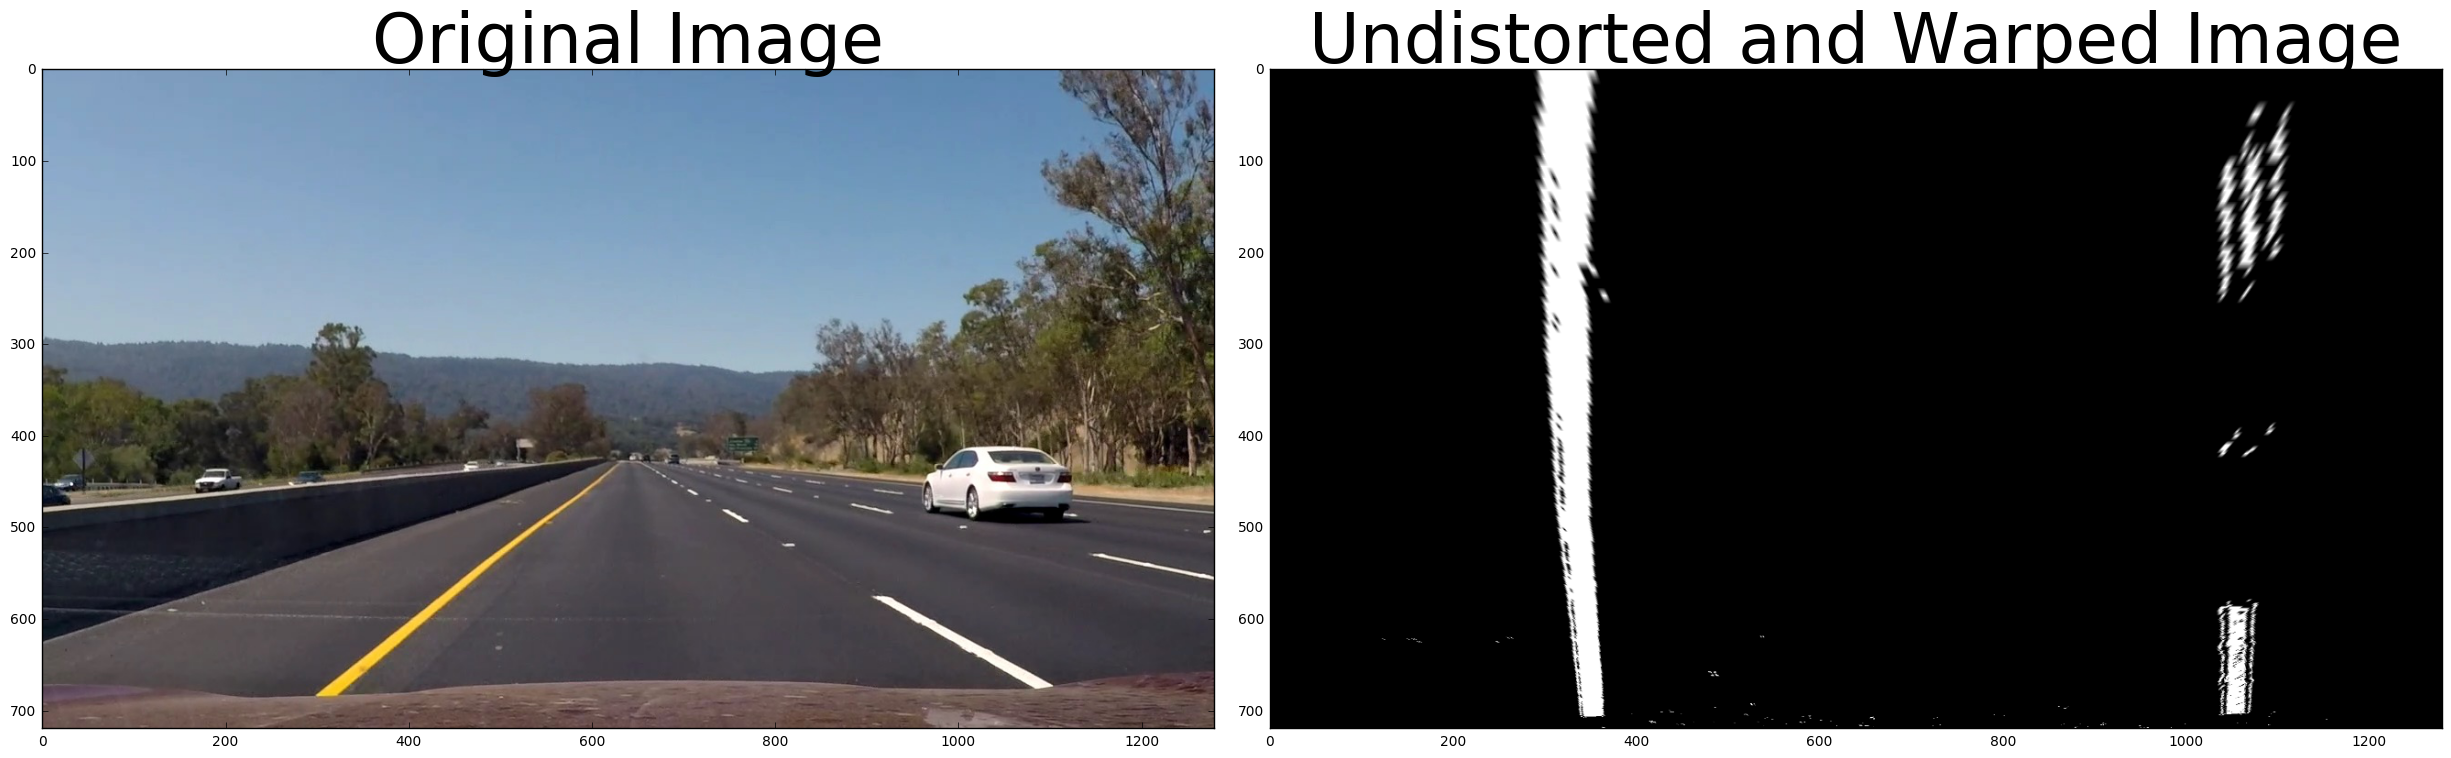

In [351]:
warped = undistort_img(combined)
       
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imageTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Filter lane-line pixels
The code bellow is from the sample code from the Udacity lecture

In [317]:
window_width = 100 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

The **get_filtered_points** will give the filtered result of the lane pixals, which is for the polynomial fitting

In [318]:
def get_filtered_points(img, window_width, window_height, margin):
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)
        l_points_filted = np.zeros_like(img)
        r_points_filted = np.zeros_like(img)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 

            l_points_filted[(img > 0) & ((l_mask == 1) ) ] = 255
            r_points_filted[(img > 0) & ((r_mask == 1) ) ] = 255

            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
    return (l_points_filted,r_points_filted,l_points,r_points)

The code bellow shows the result of result filtered by window template

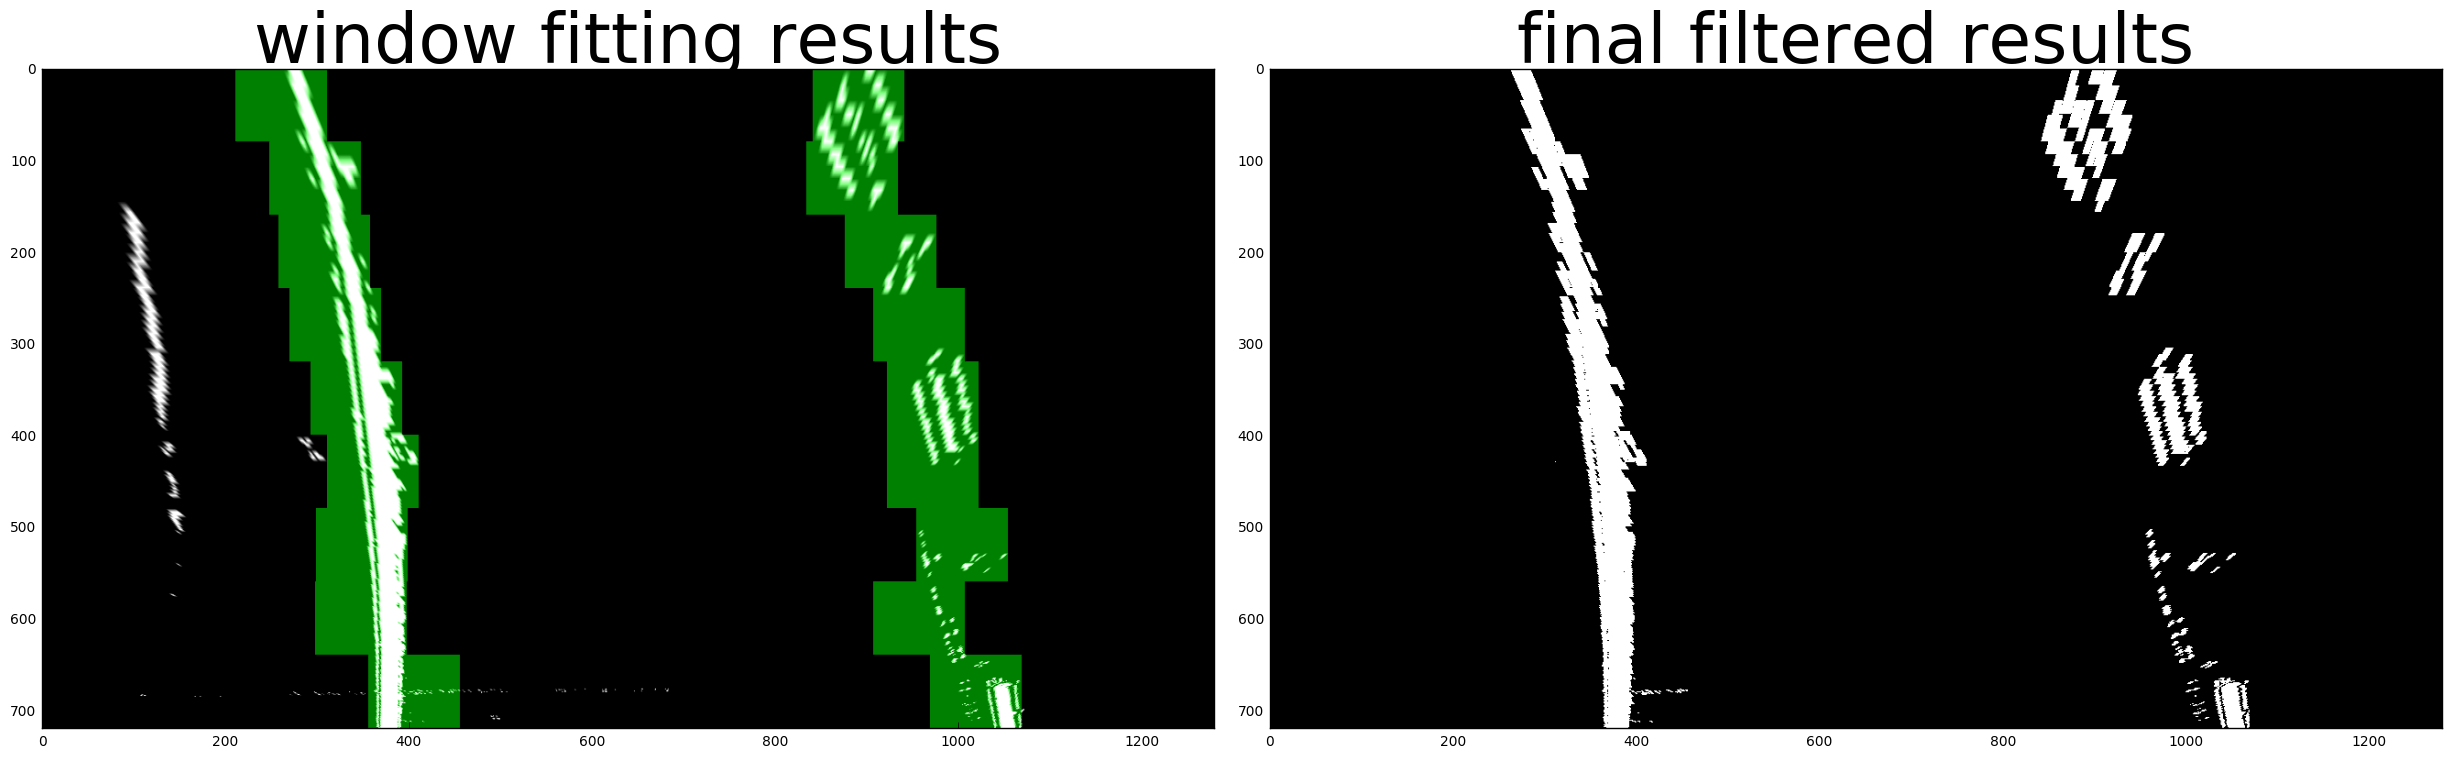

In [319]:
filtered_points = get_filtered_points(warped, window_width, window_height, margin)
l_points = filtered_points[:][0]
r_points = filtered_points[:][1]

t_l_points = filtered_points[:][2]
t_r_points = filtered_points[:][3]

result = np.array(r_points+l_points,np.uint8)
template = np.array(t_r_points+t_l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channle 
warpp = np.array(warped*255,np.uint8)
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage = np.array(cv2.merge((warpp,warpp,warpp)),np.uint8) # making the original road pixels 3 color channels
output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(output)
ax1.set_title('window fitting results', fontsize=50)
ax2.imshow(result,cmap='gray')
ax2.set_title('final filtered results', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Polynomial fitness

After generate the lane-line pixals, I used the polynomial fit function to get the polynomial parameter of lane-lines

In [320]:
def fit_as_polynome(points):
    curve_points_l_row = []
    curve_points_l_column = []
    curve_points_r_row = []
    curve_points_r_column = []
    for x in range(0,720):
        for y in range(0,1280):
            if points[0][x][y] > 0:
                curve_points_l_row.append(x)
                curve_points_l_column.append(y)
            if points[1][x][y] > 0:
                curve_points_r_row.append(x)
                curve_points_r_column.append(y)

    ploty = np.linspace(0, 719, num=720)
    curve_points_l_row = np.array(curve_points_l_row)
    curve_points_l_column = np.array(curve_points_l_column)
    curve_points_r_row = np.array(curve_points_r_row)
    curve_points_r_column = np.array(curve_points_r_column)
    
        # Fit a second order polynomial to each fake lane line
    left_fit = np.polyfit(curve_points_l_row, curve_points_l_column, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(curve_points_r_row, curve_points_r_column, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ((left_fitx,ploty,curve_points_l_row,curve_points_l_column,left_fit),(right_fitx,ploty,curve_points_r_row,curve_points_r_column,right_fit))
    

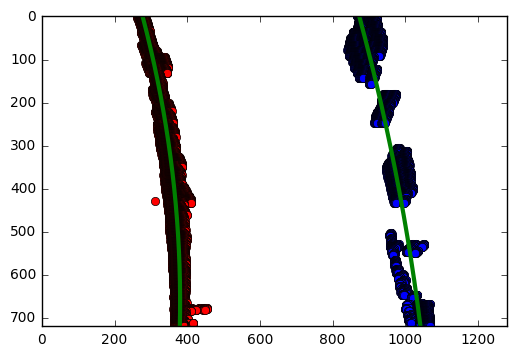

In [321]:
# Plot up the fake data
polynome_data = fit_as_polynome(filtered_points)
plt.plot(polynome_data[0][3], polynome_data[0][2], 'o', color='red')
plt.plot(polynome_data[1][3], polynome_data[1][2], 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(polynome_data[0][0], polynome_data[0][1], color='green', linewidth=3)
plt.plot(polynome_data[1][0], polynome_data[1][1], color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

## Measuring Curvature and Offset

The code bellow measures the curvature of the lane-line both in pixals and in real world. The parameter I choosed is:

* y: 25/720 meters/pixal
* x: 3.7/700 meters/pixal

In [322]:
def get_polynome_result(polynome_data):
    y_eval = np.max(polynome_data[0][1])
    left_curverad = ((1 + (2*polynome_data[0][4][0]*y_eval + polynome_data[0][4][1])**2)**1.5) \
                                 /np.absolute(2*polynome_data[0][4][0])

    y_eval = np.max(polynome_data[1][1])
    right_curverad = ((1 + (2*polynome_data[1][4][0]*y_eval + polynome_data[1][4][1])**2)**1.5) \
                                    /np.absolute(2*polynome_data[1][4][0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(polynome_data[0][2]*ym_per_pix, polynome_data[0][3]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(polynome_data[1][2]*ym_per_pix, polynome_data[1][3]*xm_per_pix, 2)
    
#     print(polynome_data[0][4])
#     print(polynome_data[1][4])
    
#     print(left_fit_cr)
#     print(right_fit_cr)
    
    y_eval = np.max(polynome_data[0][1]) * ym_per_pix
    left_curverad_world = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad_world = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
        
#     print(left_curverad_world)
#     print(right_curverad_world)
    # Now our radius of curvature is in meters
    offset = ((polynome_data[0][4][0]*720**2 + polynome_data[0][4][1]*720 + polynome_data[0][4][2]) + (polynome_data[1][4][0]*720**2 + polynome_data[1][4][1]*720 + polynome_data[1][4][2])) / 2 - (1280/2) 
    
    offset_world = offset * xm_per_pix
    
    return (left_curverad,right_curverad,left_curverad_world,right_curverad_world,offset,offset_world)

In [323]:
polynome_result = get_polynome_result(polynome_data)
print(polynome_result[0], polynome_result[1])
print(polynome_result[2], 'm', polynome_result[3], 'm')
print(polynome_result[4], polynome_result[5], 'm')

2124.56763045 4344.26708937
484.081941158 m 959.73925503 m
70.7923342482 0.374188052455 m


## Merge back to original image 

In [269]:
def merge_inv_back_to_img(image, warped_img, data, inverse_m):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([data[0][0], data[0][1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([data[1][0], data[1][1]])))])
    pts = np.hstack((pts_left, pts_right))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_m, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
    

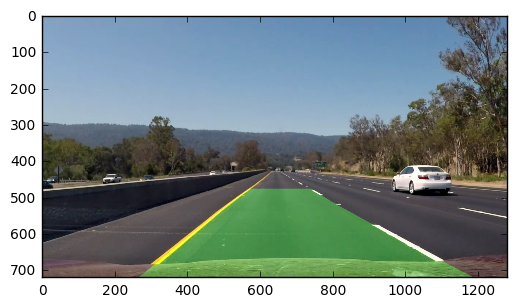

In [270]:
Minv = get_m_transform()[1]
result_img = merge_inv_back_to_img(imageTest, warped, polynome_data, Minv)
plt.imshow(result_img)

# Final Code

I filtered the result by average recent 10 result of iterations, and dropout ones that looks like invalid.

If the curvature of left and right lane lines looks like:

1. Similar curvature
2. Separated by approximately the right distance horizontally
3. Roughly parallel

by comparing their polynomial parameters, I'll decide it as a valid result.
The radius of the curvation is the average result of the left and right lane-lines

In [271]:
n_iters = 10

In [272]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # polynomial coefficients of lastn iterations
        self.recent_fit = [[np.array([False])]]
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def update_line(self):
        self.recent_xfitted.append(self.allx)
        self.recent_fit.append(self.current_fit)
        
        if len(self.recent_xfitted) > n_iters:
            self.recent_xfitted.remove(self.recent_xfitted[0])
            
        if len(self.recent_fit) > n_iters:
            self.recent_fit.remove(self.recent_fit[0])
            
        self.bestx = sum(self.recent_xfitted)/n_iters
#         self.best_fit = sum(self.recent_fit)/n_iters
        
#         print(self.allx.shape)
#         print(self.bestx.shape)
        
            
        
        

In [273]:
left_line = Line()
right_line = Line()


In [274]:
def is_valid_line(l_line, r_line):
    dif_c1 = abs(l_line.current_fit[0] - r_line.current_fit[0])
    dif_c2 = abs(l_line.current_fit[1] - r_line.current_fit[1])
    dif_c3 = abs(l_line.current_fit[2] - r_line.current_fit[2])
    if (dif_c1 < 0.001) & (dif_c2 < 0.5) & (dif_c3 < 900) & (dif_c3 > 500):
        return True
    else:
        return False
    

In [335]:
def process_image(image):
    threshould_img = get_threshold_image(image)
    warped_img = undistort_img(threshould_img)
    
    window_width = 100 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    filtered_result = get_filtered_points(warped_img, window_width, window_height, margin)
    
    data = fit_as_polynome(filtered_result)
    
    p_result = get_polynome_result(data)
    
    result_s = "Radius is %.1f m, and %f m left of the center"% ((p_result[2]+p_result[3])/2,p_result[5])
#     print(result_s)
    
    left_line.current_fit = data[0][4]
    left_line.allx = data[0][0]
    left_line.ally = data[0][1]
    
    right_line.current_fit = data[1][4]
    right_line.allx = data[1][0]
    right_line.ally = data[1][1]
    
    if is_valid_line(left_line, right_line):
        left_line.update_line()
        right_line.update_line()
        
    Minv = get_m_transform()[1]

    if len(left_line.recent_xfitted) < n_iters:
        format_data = ((left_line.allx,left_line.ally),(right_line.allx,right_line.ally))
    else:   
        format_data = ((left_line.bestx,left_line.ally),(right_line.bestx,right_line.ally))
    
    result_img = merge_inv_back_to_img(image, warped_img, format_data, Minv)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result_img,result_s,(100,100), font, 1,(255,255,255),2)
    return result_img

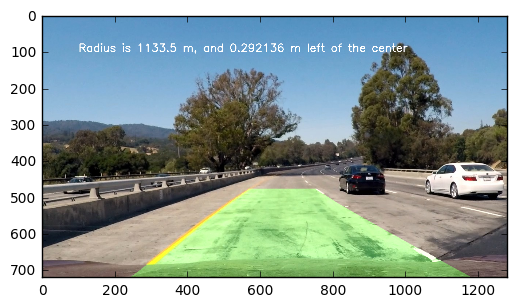

In [336]:
left_line = Line()
right_line = Line()
imageTest = mpimg.imread('test_images/test1.jpg')
imageResult = process_image(imageTest)
plt.imshow(imageResult)

In [359]:
from moviepy.editor import VideoFileClip

output = 'output_c.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_c.mp4
[MoviePy] Writing video output_c.mp4


100%|██████████| 485/485 [08:56<00:00,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_c.mp4 

CPU times: user 8min 49s, sys: 35.4 s, total: 9min 25s
Wall time: 8min 57s


## Old codes

Those codes bellow are the ones that I use to filter the lane-line pixals, it's based on histogram instead of the convolution method

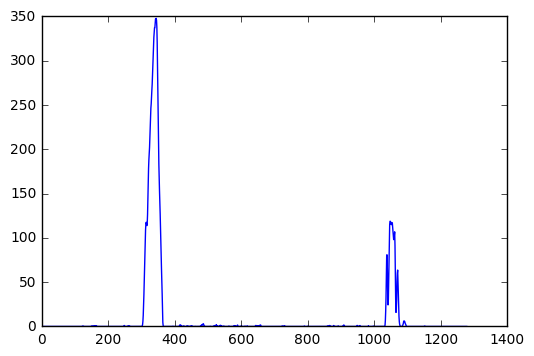

In [353]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

349
341
333
329
326
323
324
323


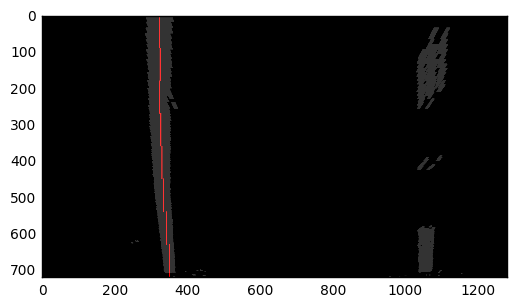

In [358]:
histogram_left = histogram[0:len(histogram)/2]
histogram_right = histogram[len(histogram)/2:len(histogram)]

idx_l = np.argmax(histogram_left)
idx_r = np.argmax(histogram_right)

warp = np.copy(warped)
warp = np.zeros((*warped.shape, 3), dtype=np.uint8)
lines = np.zeros((*warped.shape, 3), dtype=np.uint8)

curve_points_l_row = []
curve_points_l_column = []
curve_points_r_row = []
curve_points_r_column = []

div = 8
for i in range(0,div):
    j = div - 1 -i
    img_j = warped[warped.shape[0]/div*j : warped.shape[0]/div*(j+1),:]
    img_j_left = img_j[:,0:len(img_j[0])/2]
    img_j_right = img_j[:,len(img_j[0])/2:len(img_j[0])]
    
    hist_data = []
    for k in range(idx_l - 50,idx_l + 50):
        left_window_l = img_j_left[:,k - 100:k]
        left_window_r = img_j_left[:,k:k + 100]
        
        hist_l = np.sum(np.sum(left_window_l[:,:], axis=0), axis =0)
        hist_r = np.sum(np.sum(left_window_r[:,:], axis=0), axis =0)
        
        if ((int)(hist_l) < 10) | ((int)(hist_r) < 10):
            hist_data.append(10000)
        else:
            hist_data.append(abs(hist_l-hist_r))
       
    center_left = np.argmin(hist_data)
    cl_min = np.min(hist_data)
    if cl_min != 10000:
        center_left = center_left + idx_l - 50
        idx_l = center_left
    
#     print(hist_data)
    
    hist_data_r = []
    for l in range(idx_r - 50,idx_r + 50):
        right_window_l = img_j_right[:,l - 100:l]
        right_window_r = img_j_right[:,l:l + 100]
              
        hist_l = np.sum(np.sum(right_window_l[:,:], axis=0), axis =0)
        hist_r = np.sum(np.sum(right_window_r[:,:], axis=0), axis =0)
        
        if ((int)(hist_l) < 10) | ((int)(hist_r) < 10):
            hist_data_r.append(10000)
#             print("abc")
        else:
            hist_data_r.append(abs(hist_l-hist_r))
    
    center_right = np.argmin(hist_data_r)
    cr_min = np.min(hist_data_r)
    if cr_min != 10000:
#     print(center_right)
        center_right = center_right + idx_r - 50
        idx_r = center_right
    
        
    print(idx_l)
    cv2.line(lines, (idx_l, (int)(warped.shape[0]/div*j)), (idx_l, (int)(warped.shape[0]/div*(j+1))), color=[255, 0, 0], thickness=2)
#     print(hist_data_r)
    
    left_img = img_j_left[:,center_left - 100:center_left+100]
    points_l = np.nonzero(left_img)
    points_l_row = points_l[0]
    points_l_column = points_l[1]
    
    points_l_row += (int)(warped.shape[0]/div*j)
    points_l_column += center_left - 100
    
    curve_points_l_row = np.concatenate((curve_points_l_row, points_l_row), axis=0)
    curve_points_l_column = np.concatenate((curve_points_l_column, points_l_column), axis=0)
    
    
    
    right_img = img_j_right[:,center_right - 100:center_right+100]
    points_r = np.nonzero(right_img)
    points_r_row = points_r[0]
    points_r_column = points_r[1]
    
    points_r_row += (int)(warped.shape[0]/div*j)
    points_r_column += center_right - 100 + (int)(len(histogram)/2)
    
    curve_points_r_row = np.concatenate((curve_points_r_row, points_r_row), axis=0)
    curve_points_r_column = np.concatenate((curve_points_r_column, points_r_column), axis=0)
    
#     right_img = img_j_right[:,center_right - 100:center_right+100]
#     points_l = np.transpose(np.nonzero(left_img))
#     curve_points_l.append(points_l)
    
#     cv2.line(warp, (center_left, (int)(warped.shape[0]/6*j)), (center_left, (int)(warped.shape[0]/6*(j+1))), 255, 2)
#     cv2.line(warp, (center_right + (int)(len(histogram)/2), (int)(warped.shape[0]/6*j)), (center_right + (int)(len(histogram)/2), (int)(warped.shape[0]/6*(j+1))), [255,0,0], 2)
    
#     print(center_left)
#     print(center_right)
# print(curve_points_l_row)       
for n in range(0,len(curve_points_l_row)):
    y = (int)(curve_points_l_row[n])
    x = (int)(curve_points_l_column[n])
    cv2.line(warp, (x, y), (x-1, y), color=[255, 255, 255], thickness=2)

for n in range(0,len(curve_points_r_row)):
    y = (int)(curve_points_r_row[n])
    x = (int)(curve_points_r_column[n])
    cv2.line(warp, (x, y), (x-1, y), color=[255, 255, 255], thickness=2)
    
    
result = cv2.addWeighted(warp, 0.2, lines, 1, 0)
    
# print(curve_points_l[0])
plt.imshow(result) 
# plt.plot(hist_l)
    

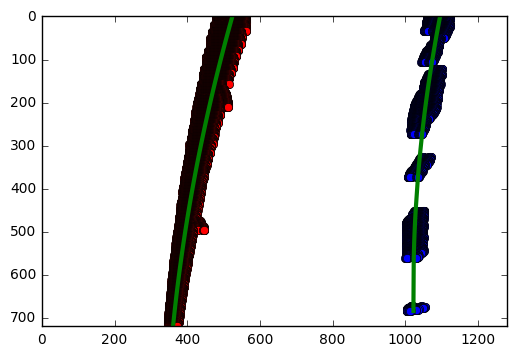

In [280]:
# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(curve_points_l_row, curve_points_l_column, 2)
left_fitx = left_fit[0]*curve_points_l_row**2 + left_fit[1]*curve_points_l_row + left_fit[2]
right_fit = np.polyfit(curve_points_r_row, curve_points_r_column, 2)
right_fitx = right_fit[0]*curve_points_r_row**2 + right_fit[1]*curve_points_r_row + right_fit[2]

# Plot up the fake data
plt.plot(curve_points_l_column, curve_points_l_row, 'o', color='red')
plt.plot(curve_points_r_column, curve_points_r_row, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, curve_points_l_row, color='green', linewidth=3)
plt.plot(right_fitx, curve_points_r_row, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [221]:
y_eval = np.max(curve_points_l_row)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])

y_eval = np.max(curve_points_r_row)
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2679.99238647 2168.81126161


In [222]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/650 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(curve_points_l_row*ym_per_pix, curve_points_l_column*xm_per_pix, 2)
right_fit_cr = np.polyfit(curve_points_r_row*ym_per_pix, curve_points_r_column*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1797.17553065 m 2014.94508477 m


In [226]:
# left_fitx = curve_points_l_row
ploty1 = curve_points_l_row
# right_fitx = curve_points_r_row
ploty2 = curve_points_r_row

[ 526.90061959  526.90061959  526.90061959 ...,  350.55295431  350.55295431
  350.55295431]


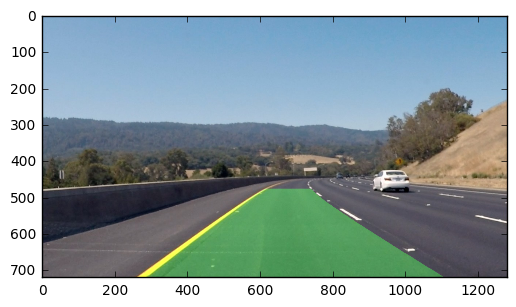

In [227]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty1]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty2])))])
pts = np.hstack((pts_left, pts_right))


# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
print(left_fitx)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (imageTest.shape[1], imageTest.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(imageTest, 1, newwarp, 0.3, 0)
plt.imshow(result)


## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.